In [40]:
import os
import shutil
import random
from cellpose import core, utils, io, models, metrics
import torch

torch.cuda.empty_cache()

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


2025-03-26 10:57:10,967 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? YES


In [43]:
import tifffile
import cv2
import numpy as np
import os

# Ruta de la carpeta que contiene las imágenes TIFF
input_folder = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi'
output_folder = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs'

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Obtener todas las imágenes TIFF de la carpeta
for filename in os.listdir(input_folder):
    if filename.endswith('.tif'):
        # Determinar si es una imagen stack (actina + núcleo) o una máscara
        if '__mask' in filename:  # Si es una máscara
            # Leer la máscara (solo un canal)
            mask_path = os.path.join(input_folder, filename)
            mask_image = tifffile.imread(mask_path)

            # Redimensionar la máscara
            nuevo_alto = int(mask_image.shape[0] / 15)
            nuevo_ancho = int(mask_image.shape[1] / 15)
            mask_image_redimensionada = cv2.resize(mask_image, (nuevo_ancho, nuevo_alto), interpolation=cv2.INTER_NEAREST)

            # Guardar la máscara redimensionada
            output_mask_path = os.path.join(output_folder, filename)
            tifffile.imwrite(output_mask_path, mask_image_redimensionada)
            print(f"Máscara redimensionada guardada como: {output_mask_path}")
        
        elif '__mask' not in filename:  # Si es una imagen stack
            # Leer la imagen stack (actina y núcleo)
            image_path = os.path.join(input_folder, filename)
            stack_imagen = tifffile.imread(image_path)

            # Asegurémonos de que la imagen tenga 2 canales (actina y núcleo)
            if stack_imagen.shape[0] != 2:
                print(f"Advertencia: {filename} no tiene 2 canales, se omitirá.")
                continue

            # Extraer los dos canales (actina y núcleo)
            canal_actina = stack_imagen[0, :, :]
            canal_nucleo = stack_imagen[1, :, :]

            # Redimensionar ambos canales
            nuevo_alto = int(canal_actina.shape[0] / 15)
            nuevo_ancho = int(canal_actina.shape[1] / 15)

            canal_actina_redimensionado = cv2.resize(canal_actina, (nuevo_ancho, nuevo_alto), interpolation=cv2.INTER_LINEAR)
            canal_nucleo_redimensionado = cv2.resize(canal_nucleo, (nuevo_ancho, nuevo_alto), interpolation=cv2.INTER_LINEAR)

            # Crear una nueva pila TIFF con las capas redimensionadas
            stack_redimensionado = np.stack([canal_actina_redimensionado, canal_nucleo_redimensionado], axis=0)

            # Guardar la imagen stack redimensionada
            output_stack_path = os.path.join(output_folder, filename)
            tifffile.imwrite(output_stack_path, stack_redimensionado)
            print(f"Imagen stack redimensionada guardada como: {output_stack_path}")


print("Procesamiento completo.")
source_dir = output_folder

Máscara redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/2_cell35__mask.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/cell6_image_stack.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/2_cell23_image_stack.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/2_cell55_image_stack.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/cell37_image_stack.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/cell11_image_stack.tif
Máscara redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/2_cell60__mask.tif
Imagen stack redimensionada guardada como: /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/2_cell10_image_stack.tif
Imagen stack redimensionada guardada 

In [3]:
output_dirs = {
    "train":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/train",
    "test":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/test"
}

In [44]:
#NO CORRER SI YA ESTÁN LAS CARPETAS HECHAS
output_dirs = {
    "train":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/train",
    "test":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/test"
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(source_dir) if f.endswith("_image_stack.tif")]
pairs = [(img, img.replace("_image_stack.tif", "__mask.tif")) for img in image_files]
random.shuffle(pairs)

total = len(pairs)
train_size=int(0.8*total)
test_size=int(0.2*total)

train_pairs = pairs[:train_size]
test_pairs=pairs[train_size:]

def move_files(pairs, dest_dir):
    for img, mask in pairs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))
        shutil.copy(os.path.join(source_dir, mask), os.path.join(dest_dir, mask))


move_files(train_pairs, output_dirs["train"])

move_files(test_pairs, output_dirs["test"])

print("dataset dividido correctamente")

dataset dividido correctamente


In [62]:
#@markdown ###Path to images and masks:

train_dir = output_dirs["train"] #@param {type:"string"}
test_dir = output_dirs["test"] #@param {type:"string"}
#Define where the patch file will be saved
base = source_dir

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto2" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_sergi_cyto2_200ep" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs = 200#@param {type:"number"}

Channel_to_use_for_training = "Red" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "Green" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


In [63]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay} '
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter __mask' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/train --pretrained_model cyto2 --chan 1 --chan2 2 --n_epochs 200 --learning_rate 0.1 --weight_decay 0.0001  --test_dir /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/test --mask_filter __mask


In [64]:
from cellpose import train 

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, image_filter='_image_stack',mask_filter='__mask')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data, 
                              train_labels=train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels, 
                              save_path=train_dir, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              SGD=True,
                              nimg_per_epoch=8,
                              rescale=False,
                              model_name=model_name,
                              min_train_masks=1,
                              batch_size=4,
                              
                            )

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()
print(diam_labels)

2025-03-26 11:14:51,332 [INFO] WRITING LOG OUTPUT TO /home/kryten/.cellpose/run.log
2025-03-26 11:14:51,332 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	linux 
python version: 	3.8.19 
torch version:  	2.3.1+cu121
2025-03-26 11:14:51,332 [INFO] >> cyto2 << model set to be used
2025-03-26 11:14:51,340 [INFO] ** TORCH CUDA version installed and working. **
2025-03-26 11:14:51,340 [INFO] >>>> using GPU (CUDA)
2025-03-26 11:14:51,368 [INFO] >>>> loading model /home/kryten/.cellpose/models/cyto2torch_0
2025-03-26 11:14:51,395 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-03-26 11:14:51,399 [INFO] not all flows are present, running flow generation for all images
2025-03-26 11:14:51,427 [INFO] 83 / 83 images in /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/train folder have labels
2025-03-26 11:14:51,428 [INFO] not all flows are present, running flow generation for all images
2025-03-26 11:14:51,435 [INFO] 21 / 21 images in /home/kry

100%|███████████████████████████████████████████| 83/83 [00:00<00:00, 85.19it/s]

2025-03-26 11:14:52,414 [INFO] computing flows for labels



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 96.61it/s]

2025-03-26 11:14:52,632 [INFO] >>> computing diameters



100%|████████████████████████████████████████| 21/21 [00:00<00:00, 24473.57it/s]

2025-03-26 11:14:52,638 [INFO] >>> using channels [1, 2]
2025-03-26 11:14:52,638 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2025-03-26 11:14:52,668 [INFO] >>> n_epochs=200, n_train=83, n_test=21
2025-03-26 11:14:52,669 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2025-03-26 11:14:52,669 [INFO] >>> saving model to /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/train/models/CP_sergi_cyto2_200ep


2025-03-26 11:14:52,967 [INFO] 0, train_loss=0.4936, test_loss=0.1044, LR=0.000000, time 0.30s
2025-03-26 11:14:53,853 [INFO] 5, train_loss=0.2666, test_loss=0.0830, LR=0.055556, time 1.18s
2025-03-26 11:14:54,713 [INFO] 10, train_loss=0.1023, test_loss=0.1050, LR=0.100000, time 2.04s
2025-03-26 11:14:56,291 [INFO] 20, train_loss=0.0902, test_loss=0.0620, LR=0.100000, time 3.62s
2025-03-26 11:14:57,828 [INFO] 30, train_loss=0.0636, test_loss=0.0522, LR=0.100000, time 5.16s
2025-03-26 11:14:59,398 [INFO] 40, train_loss=0.0602, test_loss=0.0426, LR=0.100000, time 6.73s
2025-03-26 11:15:00,987 [INFO] 50, train_loss=0.0490, test_loss=0.0428, LR=0.100000, time 8.32s
2025-03-26 11:15:02,534 [INFO] 60, train_loss=0.0364, test_loss=0.0390, LR=0.100000, time 9.86s
2025-03-26 11:15:04,110 [INFO] 70, train_loss=0.0364, test_loss=0.0401, LR=0.100000, time 11.44s
2025-03-26 11:15:05,734 [INFO] 80, train_loss=0.0456, test_loss=0.0402, LR=0.100000, time 13.06s
2025-03-26 11:15:07,319 [INFO] 90, train

In [65]:
#evaluate with test data
from sklearn.metrics import accuracy_score
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, image_filter='_image_stack', mask_filter='__mask')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2]
                   )[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
#accuracy = accuracy_score(test_labels, masks)
#print("Accuracy:", accuracy)
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2025-03-26 11:15:29,212 [INFO] not all flows are present, running flow generation for all images
2025-03-26 11:15:29,219 [INFO] 21 / 21 images in /home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs/test folder have labels
2025-03-26 11:15:29,649 [INFO] 100%|##########| 21/21 [00:00<00:00, 48.91it/s]

>>> average precision at iou threshold 0.5 = 0.913


In [ ]:
#probar otra validación
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(model, train_data, train_labels, cv=5)
# Calculate the average performance across all folds
mean_accuracy = scores.mean()
print("Mean Accuracy:", mean_accuracy)

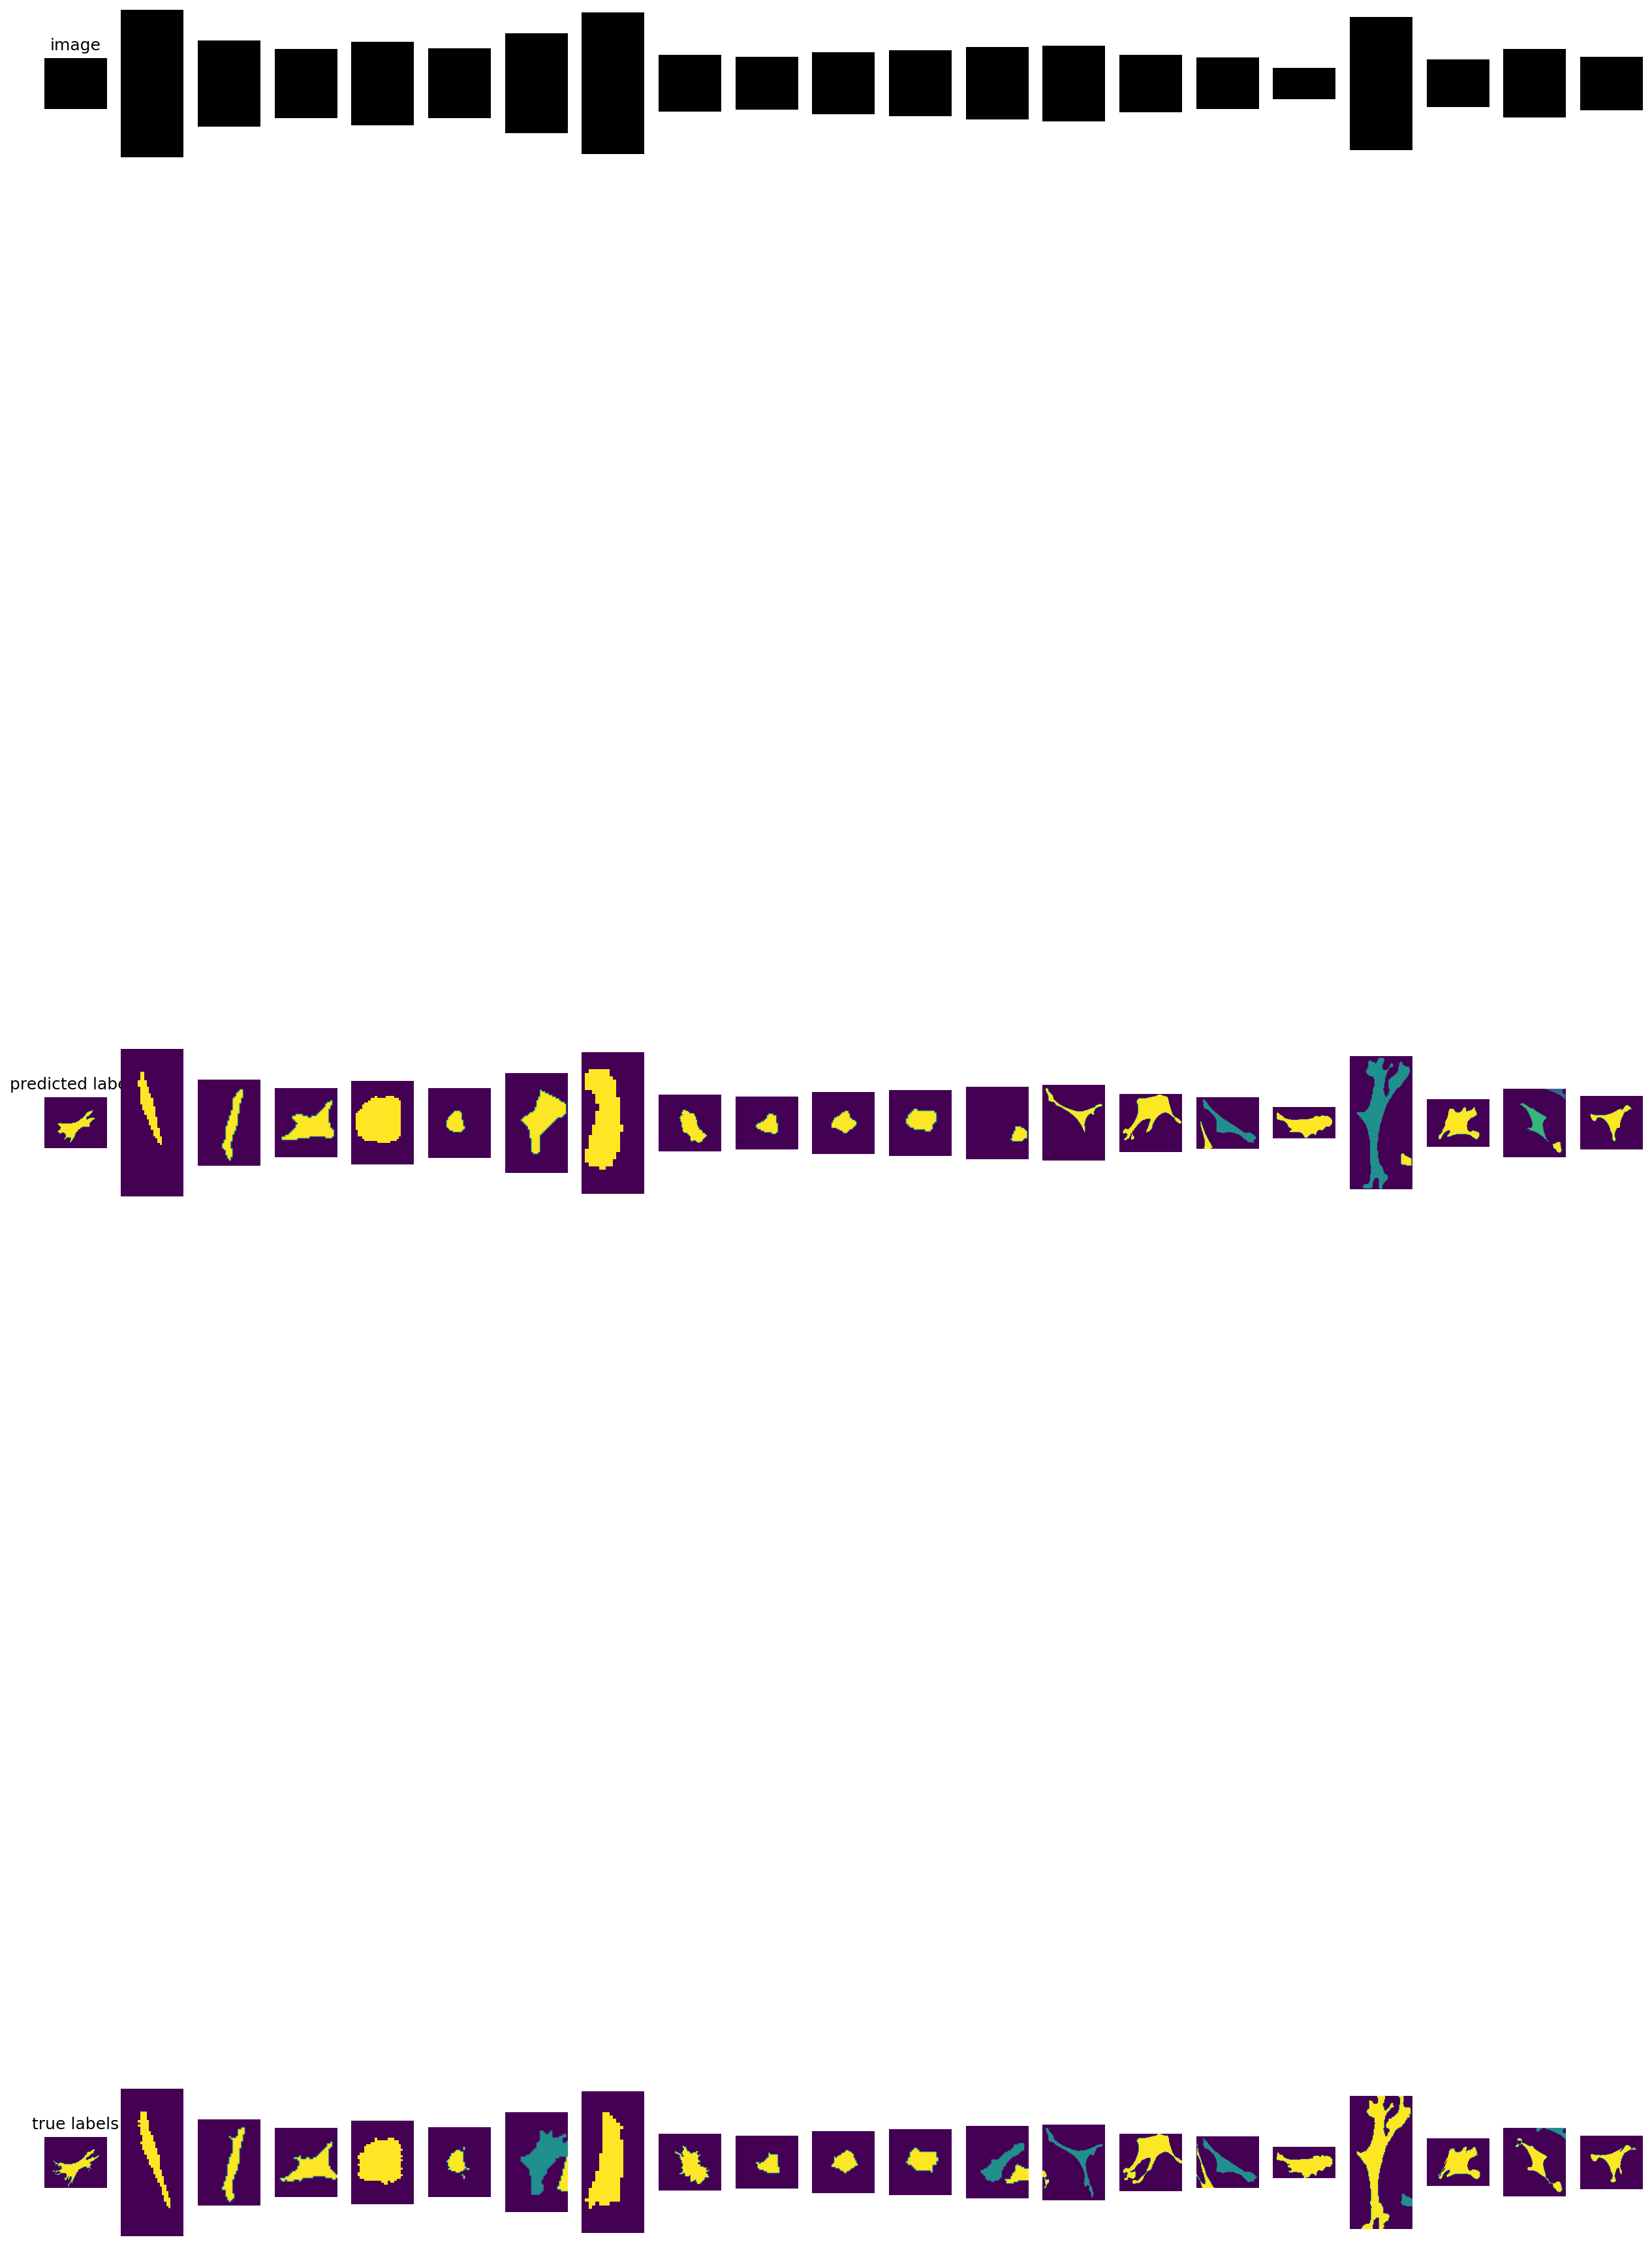

In [66]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(48,32), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_dir), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    img = np.clip(img, 0, 1) 
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_dir), len(train_dir) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_dir), 2*len(train_dir) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

In [15]:
#check the model

model_path = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi'#@param {type:"string"}

#@markdown ###Path to images:

dir = "/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test" #@param {type:"string"}


In [36]:
#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

In [32]:
files = io.get_image_files(dir, '__mask')
dir_eval = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval'
os.makedirs(dir, exist_ok=True)
for f in files:
    dst = dir + os.path.split(f)[1]
    print(f'{f} > {dst}')
    shutil.copyfile(f, dst)

/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell8__mask.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell8__mask.tif
/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell8_image_stack.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell8_image_stack.tif
/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell11__mask.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell11__mask.tif
/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell11_image_stack.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell11_image_stack.tif
/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell17__mask.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell17__mask.tif
/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell17_image_stack.tif > /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/eval2_cell17_image_stack.tif
/home/kryten/Desktop/Imatges_AIna/data

In [41]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '__mask')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
#diameter = model.diam_labels if diameter==0 else diameter
image = io.imread('/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/val/2_cell33_image_stack.tif')
# run model on test images
masks, flows, styles = model.eval(image, 
                                  channels=[chan, chan2],
                                  #diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell8_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell11_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell17_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell23_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell31_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell45_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell53_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell55_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell56_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell57_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/cell2_image_stack.tif', '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/tes

TypeError: Invalid shape (668, 544, 2) for image data

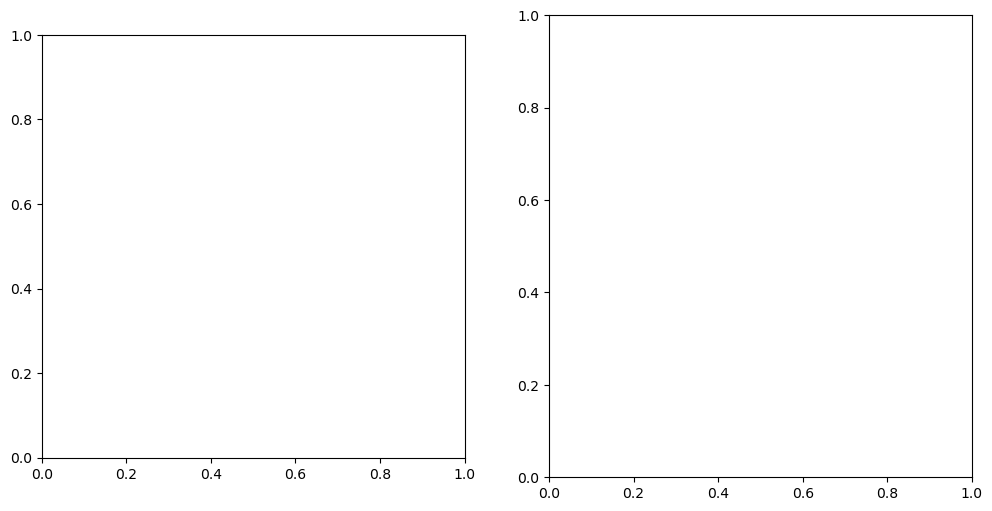

In [45]:

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(48,32), dpi=150)

img = image.copy()
plt.subplot(3,len(train_dir), k+1)
img = np.vstack((img, np.zeros_like(img)[:1]))
img = img.transpose(1,2,0)
img = np.clip(img, 0, 1) 
plt.imshow(img)
plt.axis('off')
if k==0:
    plt.title('image')

plt.subplot(3,len(train_dir), len(train_dir) + k+1)
plt.imshow(masks[k])
plt.axis('off')
if k==0:
    plt.title('predicted labels')

plt.subplot(3,len(train_dir), 2*len(train_dir) + k+1)
plt.imshow(test_labels[k])
plt.axis('off')
if k==0:
    plt.title('true labels')
plt.tight_layout()

In [38]:
from cellpose import io

io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      files, 
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)), 
                      )

In [39]:
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )
    

2025-03-17 12:15:04,313 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:04,636 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:04,637 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:06,443 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:06,445 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:06,447 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:06,449 [WARNING] no masks found, will not save PNG or outlines
2025-03-17 12:15:06,452 [WARNING] no masks found, will not save PNG or outlines


2025-03-17 12:16:09,948 [CRITICAL] ERROR: could not read file, 'NoneType' object has no attribute 'ndim'


[ WARN:0@5900.922] global loadsave.cpp:241 findDecoder imread_('/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test/2_cell8_image_stack_cp_output.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

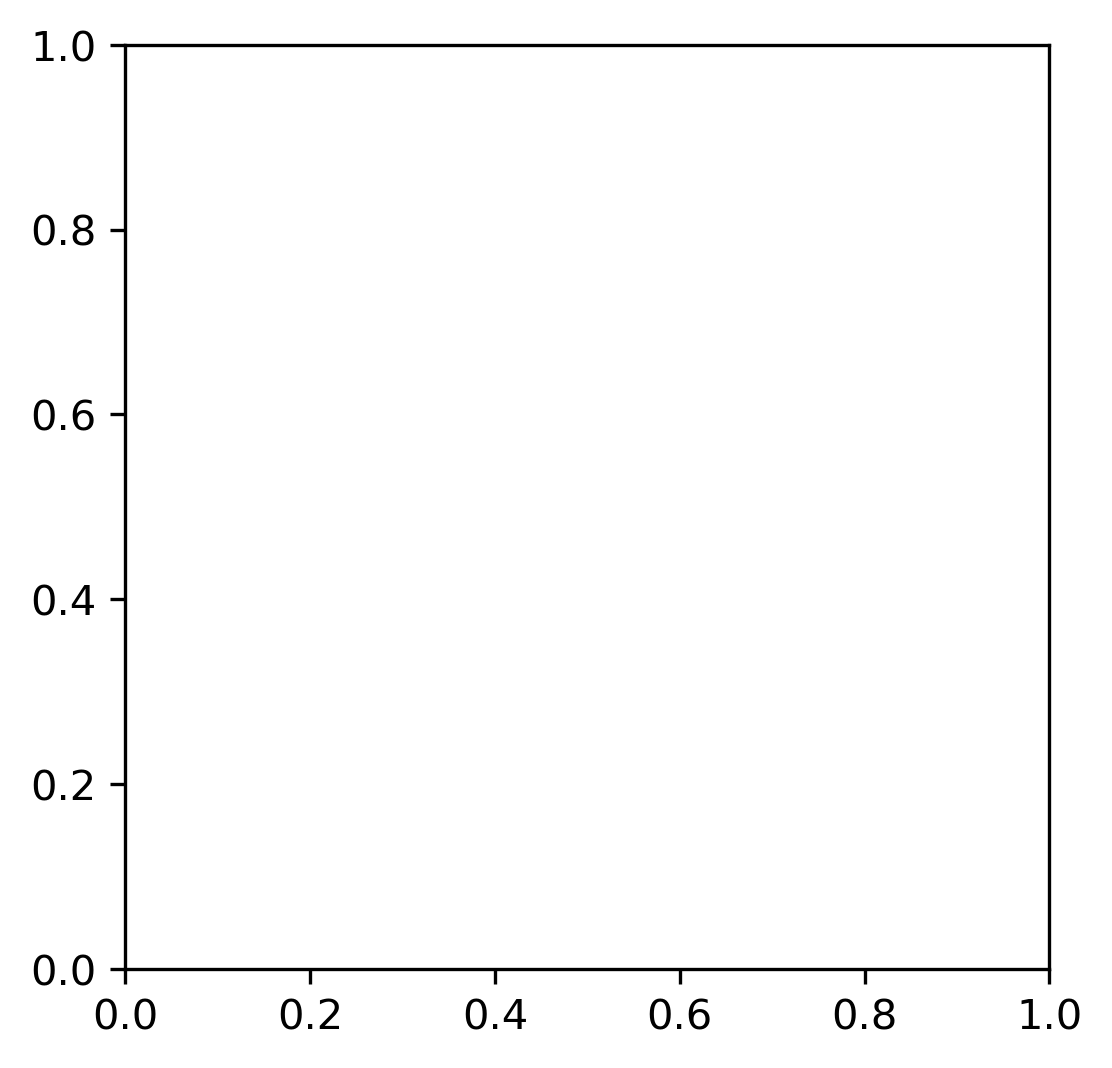

In [40]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')